# Import

In [24]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [25]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0.95
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 5000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [26]:
file_path

'CIFAR10/MyResNet32_256_SGD_95'

# Loading the dataset

## Define Dateloader

In [27]:
from src.Mydataloader import LoadDataset

In [28]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  47500
- Length of Valid Set :  2500
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [29]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None
    
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomHorizontalFlip(p=0.5)
) 256
valid.transforms = Compose(
      ToTensor()
      Submean()
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
) 256


## Confirm that the dataset is loaded properly

In [30]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-1.1593e-09, -2.1114e-09, -2.3502e-09])
Shape of y: torch.Size([256]) torch.int64


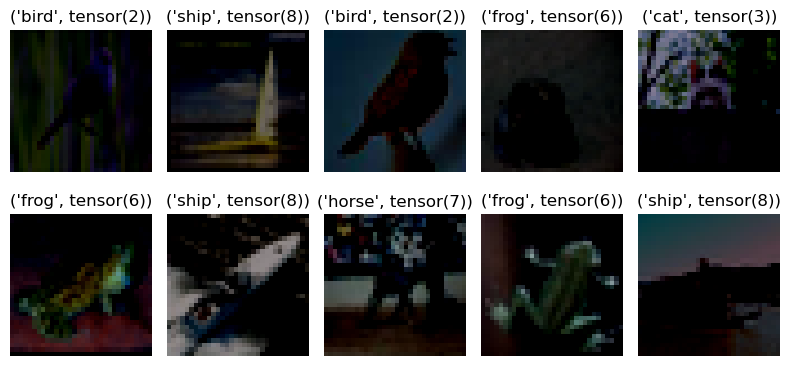

In [31]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [32]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [35]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [36]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [37]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [38]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

In [39]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [40]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        "logs/" + file_path + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_path)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD_95
Current epoch is 2067
Current learning rate: 0.1


In [41]:
# CHECK = 1999
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

# [Training Loop]

In [42]:
from src.Mytraining import DoTraining

In [43]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 2068/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.76it/s]

Train Loss: 0.0019 | Train Acc: 85.71%


Valid Loss: 0.7791 | Valid Acc: 76.36%
Test  Loss: 1.0528 | Test Acc: 71.15%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2069/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.12it/s]


Train Loss: 0.0017 | Train Acc: 89.29%
Valid Loss: 0.4424 | Valid Acc: 84.88%
Test  Loss: 0.6923 | Test Acc: 78.17%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2070/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.01it/s]


Train Loss: 0.0010 | Train Acc: 92.14%
Valid Loss: 0.4780 | Valid Acc: 85.24%
Test  Loss: 0.8323 | Test Acc: 77.98%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2071/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.37it/s]


Train Loss: 0.0017 | Train Acc: 90.71%
Valid Loss: 0.3481 | Valid Acc: 88.40%
Test  Loss: 0.7472 | Test Acc: 80.54%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2072/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.23it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.4077 | Valid Acc: 86.76%
Test  Loss: 0.8126 | Test Acc: 79.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2073/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.38it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.4176 | Valid Acc: 87.12%
Test  Loss: 0.8064 | Test Acc: 80.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2074/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.27it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.4081 | Valid Acc: 87.04%
Test  Loss: 0.8914 | Test Acc: 80.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2075/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.50it/s]


Train Loss: 0.0005 | Train Acc: 97.14%
Valid Loss: 0.5129 | Valid Acc: 85.60%
Test  Loss: 0.9871 | Test Acc: 79.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2076/5000] :


100%|██████████| 186/186 [00:13<00:00, 14.30it/s]


Train Loss: 0.0006 | Train Acc: 95.00%
Valid Loss: 0.3354 | Valid Acc: 90.16%
Test  Loss: 0.8343 | Test Acc: 81.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2077/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.99it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.6451 | Valid Acc: 84.20%
Test  Loss: 1.0528 | Test Acc: 77.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2078/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.99it/s]


Train Loss: 0.0004 | Train Acc: 97.86%
Valid Loss: 0.3872 | Valid Acc: 88.96%
Test  Loss: 0.8065 | Test Acc: 81.87%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2079/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.83it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.3942 | Valid Acc: 89.28%
Test  Loss: 0.8792 | Test Acc: 81.47%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2080/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.42it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.3150 | Valid Acc: 91.20%
Test  Loss: 0.7898 | Test Acc: 82.82%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2081/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.3521 | Valid Acc: 90.12%
Test  Loss: 0.8022 | Test Acc: 82.52%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2082/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.36it/s]


Train Loss: 0.0006 | Train Acc: 96.43%
Valid Loss: 0.4358 | Valid Acc: 88.08%
Test  Loss: 0.8934 | Test Acc: 81.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2083/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.15it/s]


Train Loss: 0.0005 | Train Acc: 96.43%
Valid Loss: 0.4809 | Valid Acc: 86.80%
Test  Loss: 0.9926 | Test Acc: 79.96%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2084/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.07it/s]


Train Loss: 0.0010 | Train Acc: 95.00%
Valid Loss: 0.4701 | Valid Acc: 87.48%
Test  Loss: 0.8766 | Test Acc: 79.82%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2085/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.4042 | Valid Acc: 88.40%
Test  Loss: 0.8273 | Test Acc: 82.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2086/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.03it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.3187 | Valid Acc: 91.24%
Test  Loss: 0.7907 | Test Acc: 83.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2087/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.07it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.4072 | Valid Acc: 89.00%
Test  Loss: 0.8954 | Test Acc: 82.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2088/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.12it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.3250 | Valid Acc: 90.60%
Test  Loss: 0.7604 | Test Acc: 83.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2089/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.30it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.2875 | Valid Acc: 92.08%
Test  Loss: 0.7796 | Test Acc: 84.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2090/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.79it/s]


Train Loss: 0.0000 | Train Acc: 99.29%
Valid Loss: 0.3275 | Valid Acc: 91.20%
Test  Loss: 0.8834 | Test Acc: 83.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2091/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2159 | Valid Acc: 93.44%
Test  Loss: 0.7171 | Test Acc: 85.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2092/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2145 | Valid Acc: 93.96%
Test  Loss: 0.7031 | Test Acc: 85.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2093/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2252 | Valid Acc: 93.24%
Test  Loss: 0.7427 | Test Acc: 84.53%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2094/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.00it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1881 | Valid Acc: 94.24%
Test  Loss: 0.6591 | Test Acc: 85.45%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2095/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1823 | Valid Acc: 94.32%
Test  Loss: 0.7142 | Test Acc: 85.84%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2096/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1799 | Valid Acc: 94.44%
Test  Loss: 0.6388 | Test Acc: 85.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2097/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.03it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1693 | Valid Acc: 94.52%
Test  Loss: 0.6254 | Test Acc: 85.81%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2098/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.34it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1695 | Valid Acc: 94.72%
Test  Loss: 0.6078 | Test Acc: 85.95%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2099/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.17it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1647 | Valid Acc: 94.60%
Test  Loss: 0.6058 | Test Acc: 85.92%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2100/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1664 | Valid Acc: 94.72%
Test  Loss: 0.5999 | Test Acc: 86.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2101/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1643 | Valid Acc: 94.56%
Test  Loss: 0.6018 | Test Acc: 86.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2102/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1635 | Valid Acc: 94.72%
Test  Loss: 0.5754 | Test Acc: 86.12%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2103/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1623 | Valid Acc: 94.76%
Test  Loss: 0.5696 | Test Acc: 86.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2104/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1616 | Valid Acc: 94.64%
Test  Loss: 0.5737 | Test Acc: 86.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2105/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.08it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1649 | Valid Acc: 94.48%
Test  Loss: 0.6025 | Test Acc: 86.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2106/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1627 | Valid Acc: 94.72%
Test  Loss: 0.5597 | Test Acc: 86.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2107/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1609 | Valid Acc: 94.92%
Test  Loss: 0.5558 | Test Acc: 86.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2108/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1609 | Valid Acc: 94.96%
Test  Loss: 0.5575 | Test Acc: 86.13%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2109/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1601 | Valid Acc: 94.96%
Test  Loss: 0.5595 | Test Acc: 86.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2110/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1607 | Valid Acc: 94.96%
Test  Loss: 0.5589 | Test Acc: 86.15%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2111/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1608 | Valid Acc: 94.84%
Test  Loss: 0.5549 | Test Acc: 86.01%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2112/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1612 | Valid Acc: 94.92%
Test  Loss: 0.5481 | Test Acc: 86.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2113/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.12it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1609 | Valid Acc: 94.88%
Test  Loss: 0.5478 | Test Acc: 86.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2114/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1576 | Valid Acc: 94.96%
Test  Loss: 0.5418 | Test Acc: 86.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2115/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.08it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1600 | Valid Acc: 94.76%
Test  Loss: 0.5495 | Test Acc: 86.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2116/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1614 | Valid Acc: 94.84%
Test  Loss: 0.5598 | Test Acc: 86.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2117/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1637 | Valid Acc: 94.72%
Test  Loss: 0.5606 | Test Acc: 86.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2118/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1606 | Valid Acc: 94.92%
Test  Loss: 0.5465 | Test Acc: 86.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2119/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.40it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1637 | Valid Acc: 94.52%
Test  Loss: 0.5525 | Test Acc: 85.99%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2120/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.19it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1628 | Valid Acc: 94.60%
Test  Loss: 0.5489 | Test Acc: 85.98%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2121/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.99it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1647 | Valid Acc: 94.72%
Test  Loss: 0.5438 | Test Acc: 86.08%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2122/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1669 | Valid Acc: 94.88%
Test  Loss: 0.5651 | Test Acc: 86.15%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2123/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1681 | Valid Acc: 94.60%
Test  Loss: 0.5658 | Test Acc: 86.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2124/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.21it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1706 | Valid Acc: 94.64%
Test  Loss: 0.5632 | Test Acc: 85.95%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2125/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1655 | Valid Acc: 94.68%
Test  Loss: 0.5511 | Test Acc: 86.13%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2126/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1680 | Valid Acc: 94.60%
Test  Loss: 0.5573 | Test Acc: 86.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2127/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.29it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1726 | Valid Acc: 94.36%
Test  Loss: 0.5626 | Test Acc: 85.94%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2128/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1713 | Valid Acc: 94.64%
Test  Loss: 0.5659 | Test Acc: 85.97%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2129/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1750 | Valid Acc: 94.52%
Test  Loss: 0.5705 | Test Acc: 86.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2130/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.31it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1782 | Valid Acc: 94.44%
Test  Loss: 0.5753 | Test Acc: 85.81%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2131/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1824 | Valid Acc: 94.12%
Test  Loss: 0.5628 | Test Acc: 85.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2132/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1824 | Valid Acc: 94.28%
Test  Loss: 0.5606 | Test Acc: 85.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2133/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.01it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1833 | Valid Acc: 94.60%
Test  Loss: 0.5703 | Test Acc: 85.75%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2134/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1864 | Valid Acc: 94.00%
Test  Loss: 0.5699 | Test Acc: 85.58%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2135/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1950 | Valid Acc: 93.92%
Test  Loss: 0.5700 | Test Acc: 85.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2136/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1957 | Valid Acc: 93.84%
Test  Loss: 0.5732 | Test Acc: 85.71%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2137/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1899 | Valid Acc: 93.64%
Test  Loss: 0.5829 | Test Acc: 85.45%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2138/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1977 | Valid Acc: 93.44%
Test  Loss: 0.5891 | Test Acc: 85.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2139/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1953 | Valid Acc: 93.44%
Test  Loss: 0.6038 | Test Acc: 85.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2140/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.1958 | Valid Acc: 93.60%
Test  Loss: 0.5924 | Test Acc: 85.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2141/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.2050 | Valid Acc: 93.52%
Test  Loss: 0.6029 | Test Acc: 85.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2142/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.69it/s]


Train Loss: 0.0044 | Train Acc: 72.86%
Valid Loss: 1.3214 | Valid Acc: 58.48%
Test  Loss: 1.3149 | Test Acc: 58.54%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2143/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.23it/s]


Train Loss: 0.0026 | Train Acc: 82.86%
Valid Loss: 0.8515 | Valid Acc: 72.20%
Test  Loss: 0.8724 | Test Acc: 72.68%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2144/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.34it/s]


Train Loss: 0.0019 | Train Acc: 89.29%
Valid Loss: 0.6666 | Valid Acc: 77.72%
Test  Loss: 0.7581 | Test Acc: 76.10%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2145/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0019 | Train Acc: 87.14%
Valid Loss: 0.5791 | Valid Acc: 81.96%
Test  Loss: 0.6425 | Test Acc: 80.08%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2146/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.82it/s]


Train Loss: 0.0007 | Train Acc: 95.71%
Valid Loss: 0.6901 | Valid Acc: 79.52%
Test  Loss: 0.8077 | Test Acc: 77.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2147/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.79it/s]


Train Loss: 0.0010 | Train Acc: 92.86%
Valid Loss: 0.5949 | Valid Acc: 81.48%
Test  Loss: 0.7002 | Test Acc: 79.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2148/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.88it/s]


Train Loss: 0.0005 | Train Acc: 96.43%
Valid Loss: 0.6543 | Valid Acc: 82.20%
Test  Loss: 0.8092 | Test Acc: 79.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2149/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.94it/s]


Train Loss: 0.0008 | Train Acc: 95.00%
Valid Loss: 0.5970 | Valid Acc: 83.80%
Test  Loss: 0.7926 | Test Acc: 80.64%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2150/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.20it/s]


Train Loss: 0.0007 | Train Acc: 94.29%
Valid Loss: 0.6066 | Valid Acc: 83.36%
Test  Loss: 0.7904 | Test Acc: 80.55%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2151/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.90it/s]


Train Loss: 0.0005 | Train Acc: 97.86%
Valid Loss: 0.6993 | Valid Acc: 82.16%
Test  Loss: 0.8718 | Test Acc: 79.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2152/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.14it/s]


Train Loss: 0.0007 | Train Acc: 95.00%
Valid Loss: 0.6619 | Valid Acc: 83.08%
Test  Loss: 0.8522 | Test Acc: 79.73%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2153/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.22it/s]


Train Loss: 0.0009 | Train Acc: 95.71%
Valid Loss: 0.7492 | Valid Acc: 81.72%
Test  Loss: 0.9840 | Test Acc: 79.00%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2154/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.17it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.6549 | Valid Acc: 83.72%
Test  Loss: 0.8922 | Test Acc: 80.92%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2155/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.21it/s]


Train Loss: 0.0005 | Train Acc: 97.14%
Valid Loss: 0.5723 | Valid Acc: 84.28%
Test  Loss: 0.7810 | Test Acc: 81.52%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2156/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.86it/s]


Train Loss: 0.0002 | Train Acc: 100.00%
Valid Loss: 0.5142 | Valid Acc: 86.72%
Test  Loss: 0.7233 | Test Acc: 82.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2157/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0006 | Train Acc: 95.71%
Valid Loss: 0.6880 | Valid Acc: 84.20%
Test  Loss: 0.9502 | Test Acc: 80.94%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2158/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.68it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.7664 | Valid Acc: 82.56%
Test  Loss: 0.9603 | Test Acc: 79.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2159/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.93it/s]


Train Loss: 0.0004 | Train Acc: 97.86%
Valid Loss: 0.6711 | Valid Acc: 84.80%
Test  Loss: 0.8568 | Test Acc: 81.69%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2160/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.13it/s]


Train Loss: 0.0004 | Train Acc: 95.71%
Valid Loss: 0.6416 | Valid Acc: 84.08%
Test  Loss: 0.8811 | Test Acc: 81.54%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2161/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0003 | Train Acc: 97.14%
Valid Loss: 0.5218 | Valid Acc: 86.84%
Test  Loss: 0.7570 | Test Acc: 83.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2162/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.85it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.6102 | Valid Acc: 85.64%
Test  Loss: 0.8272 | Test Acc: 82.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2163/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.73it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.5633 | Valid Acc: 85.80%
Test  Loss: 0.7716 | Test Acc: 82.69%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2164/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.25it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.6004 | Valid Acc: 85.32%
Test  Loss: 0.8541 | Test Acc: 81.92%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2165/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.38it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.6515 | Valid Acc: 84.56%
Test  Loss: 0.9112 | Test Acc: 81.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2166/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.50it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.6142 | Valid Acc: 86.00%
Test  Loss: 0.8690 | Test Acc: 82.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2167/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.05it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.5960 | Valid Acc: 85.36%
Test  Loss: 0.7915 | Test Acc: 82.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2168/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.32it/s]


Train Loss: 0.0003 | Train Acc: 97.14%
Valid Loss: 0.5204 | Valid Acc: 87.64%
Test  Loss: 0.7307 | Test Acc: 84.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2169/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.96it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.6041 | Valid Acc: 86.04%
Test  Loss: 0.7961 | Test Acc: 83.66%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2170/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.5786 | Valid Acc: 86.80%
Test  Loss: 0.8192 | Test Acc: 83.49%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2171/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.82it/s]


Train Loss: 0.0004 | Train Acc: 95.71%
Valid Loss: 0.5287 | Valid Acc: 87.44%
Test  Loss: 0.7526 | Test Acc: 83.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2172/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.82it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.6431 | Valid Acc: 85.28%
Test  Loss: 0.8625 | Test Acc: 82.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2173/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.11it/s]


Train Loss: 0.0006 | Train Acc: 97.14%
Valid Loss: 0.8906 | Valid Acc: 80.40%
Test  Loss: 1.1280 | Test Acc: 78.71%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2174/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.6544 | Valid Acc: 84.16%
Test  Loss: 0.8545 | Test Acc: 81.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2175/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.66it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.5577 | Valid Acc: 86.24%
Test  Loss: 0.7655 | Test Acc: 83.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2176/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.81it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.6916 | Valid Acc: 83.80%
Test  Loss: 0.9379 | Test Acc: 81.50%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2177/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.42it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.6790 | Valid Acc: 84.80%
Test  Loss: 0.9213 | Test Acc: 81.69%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2178/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.24it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.5995 | Valid Acc: 85.84%
Test  Loss: 0.8141 | Test Acc: 82.80%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2179/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.37it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.6083 | Valid Acc: 86.44%
Test  Loss: 0.8556 | Test Acc: 83.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2180/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.33it/s]


Train Loss: 0.0004 | Train Acc: 97.86%
Valid Loss: 0.6367 | Valid Acc: 84.96%
Test  Loss: 0.8375 | Test Acc: 82.45%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2181/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.19it/s]


Train Loss: 0.0004 | Train Acc: 98.57%
Valid Loss: 0.6051 | Valid Acc: 86.12%
Test  Loss: 0.8582 | Test Acc: 82.54%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2182/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.7113 | Valid Acc: 83.72%
Test  Loss: 0.9172 | Test Acc: 81.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2183/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.6317 | Valid Acc: 84.88%
Test  Loss: 0.7935 | Test Acc: 82.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2184/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0005 | Train Acc: 97.14%
Valid Loss: 0.5607 | Valid Acc: 86.40%
Test  Loss: 0.8580 | Test Acc: 82.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2185/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.12it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.5751 | Valid Acc: 85.96%
Test  Loss: 0.7615 | Test Acc: 83.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2186/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.75it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.6314 | Valid Acc: 85.24%
Test  Loss: 0.8778 | Test Acc: 82.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2187/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.88it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.5374 | Valid Acc: 86.76%
Test  Loss: 0.7964 | Test Acc: 82.98%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2188/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.16it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.5650 | Valid Acc: 86.40%
Test  Loss: 0.7698 | Test Acc: 83.81%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2189/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.14it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.4964 | Valid Acc: 88.00%
Test  Loss: 0.7485 | Test Acc: 84.61%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2190/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4750 | Valid Acc: 88.28%
Test  Loss: 0.7060 | Test Acc: 85.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2191/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4434 | Valid Acc: 89.28%
Test  Loss: 0.6788 | Test Acc: 85.96%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2192/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4199 | Valid Acc: 89.52%
Test  Loss: 0.6796 | Test Acc: 86.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2193/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4077 | Valid Acc: 89.84%
Test  Loss: 0.6338 | Test Acc: 86.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2194/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3905 | Valid Acc: 89.88%
Test  Loss: 0.6357 | Test Acc: 86.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2195/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3903 | Valid Acc: 89.88%
Test  Loss: 0.6188 | Test Acc: 86.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2196/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.03it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3882 | Valid Acc: 89.76%
Test  Loss: 0.6048 | Test Acc: 86.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2197/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.08it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3825 | Valid Acc: 89.80%
Test  Loss: 0.6083 | Test Acc: 86.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2198/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3760 | Valid Acc: 90.00%
Test  Loss: 0.5978 | Test Acc: 86.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2199/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3689 | Valid Acc: 90.16%
Test  Loss: 0.5881 | Test Acc: 86.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2200/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3675 | Valid Acc: 89.80%
Test  Loss: 0.5869 | Test Acc: 86.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2201/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.23it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3641 | Valid Acc: 89.84%
Test  Loss: 0.5770 | Test Acc: 86.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2202/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.84it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3643 | Valid Acc: 90.12%
Test  Loss: 0.5714 | Test Acc: 86.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2203/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.62it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3576 | Valid Acc: 90.16%
Test  Loss: 0.5838 | Test Acc: 86.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2204/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.99it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3567 | Valid Acc: 89.84%
Test  Loss: 0.5706 | Test Acc: 86.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2205/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3581 | Valid Acc: 89.84%
Test  Loss: 0.5521 | Test Acc: 86.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2206/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3557 | Valid Acc: 89.92%
Test  Loss: 0.5454 | Test Acc: 86.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2207/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3482 | Valid Acc: 90.08%
Test  Loss: 0.5632 | Test Acc: 86.50%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2208/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.83it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3487 | Valid Acc: 90.00%
Test  Loss: 0.5691 | Test Acc: 86.47%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2209/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.59it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3528 | Valid Acc: 89.92%
Test  Loss: 0.5572 | Test Acc: 86.50%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2210/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3483 | Valid Acc: 90.00%
Test  Loss: 0.5394 | Test Acc: 86.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2211/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.84it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3480 | Valid Acc: 89.92%
Test  Loss: 0.5435 | Test Acc: 86.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2212/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.01it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3521 | Valid Acc: 89.92%
Test  Loss: 0.5368 | Test Acc: 86.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2213/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3527 | Valid Acc: 89.88%
Test  Loss: 0.5393 | Test Acc: 86.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2214/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.10it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3467 | Valid Acc: 90.04%
Test  Loss: 0.5541 | Test Acc: 86.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2215/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3485 | Valid Acc: 89.92%
Test  Loss: 0.5388 | Test Acc: 86.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2216/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3477 | Valid Acc: 89.72%
Test  Loss: 0.5437 | Test Acc: 86.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2217/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3493 | Valid Acc: 89.88%
Test  Loss: 0.5594 | Test Acc: 86.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2218/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3488 | Valid Acc: 90.08%
Test  Loss: 0.5412 | Test Acc: 86.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2219/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.22it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3554 | Valid Acc: 89.80%
Test  Loss: 0.5462 | Test Acc: 86.16%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2220/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.18it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3525 | Valid Acc: 89.68%
Test  Loss: 0.5376 | Test Acc: 86.15%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2221/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3525 | Valid Acc: 89.72%
Test  Loss: 0.5467 | Test Acc: 86.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2222/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.03it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3540 | Valid Acc: 89.68%
Test  Loss: 0.5350 | Test Acc: 86.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2223/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3581 | Valid Acc: 89.80%
Test  Loss: 0.5459 | Test Acc: 86.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2224/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.23it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3601 | Valid Acc: 89.72%
Test  Loss: 0.5333 | Test Acc: 86.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2225/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.69it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3561 | Valid Acc: 89.76%
Test  Loss: 0.5636 | Test Acc: 86.11%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2226/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3542 | Valid Acc: 89.80%
Test  Loss: 0.5507 | Test Acc: 86.05%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2227/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.19it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3606 | Valid Acc: 89.64%
Test  Loss: 0.5521 | Test Acc: 86.19%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2228/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3602 | Valid Acc: 89.44%
Test  Loss: 0.5706 | Test Acc: 85.88%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2229/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3618 | Valid Acc: 89.44%
Test  Loss: 0.5501 | Test Acc: 85.83%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2230/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.53it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3622 | Valid Acc: 89.40%
Test  Loss: 0.5683 | Test Acc: 85.87%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2231/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.31it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3693 | Valid Acc: 88.96%
Test  Loss: 0.5507 | Test Acc: 85.97%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2232/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.27it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3889 | Valid Acc: 89.28%
Test  Loss: 0.5762 | Test Acc: 85.53%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2233/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3755 | Valid Acc: 89.52%
Test  Loss: 0.5650 | Test Acc: 85.51%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2234/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.59it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3784 | Valid Acc: 89.52%
Test  Loss: 0.5619 | Test Acc: 85.70%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2235/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.84it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3823 | Valid Acc: 89.44%
Test  Loss: 0.5676 | Test Acc: 85.48%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2236/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3817 | Valid Acc: 89.48%
Test  Loss: 0.5765 | Test Acc: 85.67%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2237/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3919 | Valid Acc: 88.92%
Test  Loss: 0.5987 | Test Acc: 85.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2238/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3895 | Valid Acc: 89.36%
Test  Loss: 0.5827 | Test Acc: 85.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2239/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3884 | Valid Acc: 89.04%
Test  Loss: 0.5935 | Test Acc: 85.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2240/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.3950 | Valid Acc: 89.28%
Test  Loss: 0.6081 | Test Acc: 85.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2241/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4112 | Valid Acc: 88.96%
Test  Loss: 0.6193 | Test Acc: 85.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2242/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.47it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4064 | Valid Acc: 89.08%
Test  Loss: 0.5943 | Test Acc: 85.14%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2243/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.4082 | Valid Acc: 88.84%
Test  Loss: 0.6243 | Test Acc: 85.12%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2244/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.26it/s]


Train Loss: 0.0031 | Train Acc: 80.00%
Valid Loss: 1.3187 | Valid Acc: 54.44%
Test  Loss: 1.3225 | Test Acc: 55.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2245/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.24it/s]


Train Loss: 0.0027 | Train Acc: 81.43%
Valid Loss: 0.8179 | Valid Acc: 75.12%
Test  Loss: 0.8712 | Test Acc: 73.94%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2246/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.25it/s]


Train Loss: 0.0020 | Train Acc: 87.86%
Valid Loss: 0.8900 | Valid Acc: 73.48%
Test  Loss: 0.9272 | Test Acc: 73.11%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2247/5000] :


100%|██████████| 186/186 [00:10<00:00, 18.10it/s]


Train Loss: 0.0018 | Train Acc: 90.00%
Valid Loss: 0.6138 | Valid Acc: 81.80%
Test  Loss: 0.6779 | Test Acc: 79.64%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2248/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.49it/s]


Train Loss: 0.0012 | Train Acc: 92.14%
Valid Loss: 0.6950 | Valid Acc: 79.64%
Test  Loss: 0.7571 | Test Acc: 78.96%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2249/5000] :


100%|██████████| 186/186 [00:13<00:00, 13.50it/s]


Train Loss: 0.0009 | Train Acc: 95.00%
Valid Loss: 0.7283 | Valid Acc: 79.28%
Test  Loss: 0.7916 | Test Acc: 78.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2250/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.95it/s]


Train Loss: 0.0006 | Train Acc: 97.86%
Valid Loss: 0.6974 | Valid Acc: 80.20%
Test  Loss: 0.7707 | Test Acc: 78.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2251/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.29it/s]


Train Loss: 0.0013 | Train Acc: 92.14%
Valid Loss: 0.6260 | Valid Acc: 82.08%
Test  Loss: 0.7254 | Test Acc: 80.17%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2252/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.55it/s]


Train Loss: 0.0010 | Train Acc: 93.57%
Valid Loss: 0.6646 | Valid Acc: 82.64%
Test  Loss: 0.7568 | Test Acc: 80.70%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2253/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.57it/s]


Train Loss: 0.0003 | Train Acc: 97.14%
Valid Loss: 0.7382 | Valid Acc: 82.08%
Test  Loss: 0.8686 | Test Acc: 79.95%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2254/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.85it/s]


Train Loss: 0.0004 | Train Acc: 96.43%
Valid Loss: 0.6021 | Valid Acc: 84.52%
Test  Loss: 0.7052 | Test Acc: 82.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2255/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.56it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.6542 | Valid Acc: 82.72%
Test  Loss: 0.7740 | Test Acc: 80.66%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2256/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.15it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.6253 | Valid Acc: 84.12%
Test  Loss: 0.7302 | Test Acc: 82.75%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2257/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.77it/s]


Train Loss: 0.0005 | Train Acc: 95.71%
Valid Loss: 0.6485 | Valid Acc: 84.08%
Test  Loss: 0.7302 | Test Acc: 83.19%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2258/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.81it/s]


Train Loss: 0.0005 | Train Acc: 95.00%
Valid Loss: 0.6701 | Valid Acc: 84.80%
Test  Loss: 0.8043 | Test Acc: 81.84%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2259/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0003 | Train Acc: 97.14%
Valid Loss: 0.6729 | Valid Acc: 84.44%
Test  Loss: 0.8188 | Test Acc: 82.80%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2260/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.80it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.7140 | Valid Acc: 83.52%
Test  Loss: 0.8823 | Test Acc: 81.67%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2261/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.16it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.7346 | Valid Acc: 83.08%
Test  Loss: 0.8684 | Test Acc: 82.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2262/5000] :


100%|██████████| 186/186 [00:11<00:00, 16.09it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.7614 | Valid Acc: 83.16%
Test  Loss: 0.9177 | Test Acc: 80.91%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2263/5000] :


100%|██████████| 186/186 [00:08<00:00, 20.76it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.7775 | Valid Acc: 82.96%
Test  Loss: 0.8943 | Test Acc: 80.81%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2264/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.17it/s]


Train Loss: 0.0008 | Train Acc: 95.00%
Valid Loss: 0.7451 | Valid Acc: 83.40%
Test  Loss: 0.8392 | Test Acc: 81.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2265/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.54it/s]


Train Loss: 0.0007 | Train Acc: 97.14%
Valid Loss: 0.6721 | Valid Acc: 83.80%
Test  Loss: 0.8192 | Test Acc: 82.06%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2266/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.88it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.5972 | Valid Acc: 85.84%
Test  Loss: 0.7993 | Test Acc: 82.93%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2267/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.02it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.8206 | Valid Acc: 82.08%
Test  Loss: 0.9749 | Test Acc: 79.81%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2268/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.37it/s]


Train Loss: 0.0005 | Train Acc: 97.86%
Valid Loss: 0.6163 | Valid Acc: 86.12%
Test  Loss: 0.7585 | Test Acc: 83.92%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2269/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.04it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.7217 | Valid Acc: 84.96%
Test  Loss: 0.8472 | Test Acc: 82.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2270/5000] :


100%|██████████| 186/186 [00:11<00:00, 16.55it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.6178 | Valid Acc: 85.96%
Test  Loss: 0.7841 | Test Acc: 83.85%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2271/5000] :


100%|██████████| 186/186 [00:12<00:00, 14.97it/s]


Train Loss: 0.0004 | Train Acc: 97.14%
Valid Loss: 0.8091 | Valid Acc: 82.96%
Test  Loss: 0.8897 | Test Acc: 82.03%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2272/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.02it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.6524 | Valid Acc: 85.64%
Test  Loss: 0.7536 | Test Acc: 83.70%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2273/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.32it/s]


Train Loss: 0.0002 | Train Acc: 98.57%
Valid Loss: 0.6700 | Valid Acc: 84.84%
Test  Loss: 0.8272 | Test Acc: 82.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2274/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.18it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.8442 | Valid Acc: 82.16%
Test  Loss: 1.0254 | Test Acc: 79.48%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2275/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.28it/s]


Train Loss: 0.0001 | Train Acc: 98.57%
Valid Loss: 0.6518 | Valid Acc: 85.64%
Test  Loss: 0.7738 | Test Acc: 83.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2276/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.19it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.6895 | Valid Acc: 84.48%
Test  Loss: 0.8105 | Test Acc: 82.89%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2277/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.26it/s]


Train Loss: 0.0003 | Train Acc: 97.86%
Valid Loss: 0.8414 | Valid Acc: 81.76%
Test  Loss: 1.0092 | Test Acc: 80.75%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2278/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.30it/s]


Train Loss: 0.0002 | Train Acc: 99.29%
Valid Loss: 0.6484 | Valid Acc: 85.60%
Test  Loss: 0.8049 | Test Acc: 82.73%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2279/5000] :


100%|██████████| 186/186 [00:11<00:00, 15.62it/s]


Train Loss: 0.0002 | Train Acc: 97.86%
Valid Loss: 0.7183 | Valid Acc: 84.56%
Test  Loss: 0.8517 | Test Acc: 82.07%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2280/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.35it/s]


Train Loss: 0.0003 | Train Acc: 98.57%
Valid Loss: 0.6957 | Valid Acc: 84.24%
Test  Loss: 0.8488 | Test Acc: 82.85%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2281/5000] :


100%|██████████| 186/186 [00:12<00:00, 15.19it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Valid Loss: 0.5990 | Valid Acc: 86.36%
Test  Loss: 0.7718 | Test Acc: 84.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2282/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.41it/s]


Train Loss: 0.0001 | Train Acc: 99.29%
Valid Loss: 0.6456 | Valid Acc: 85.56%
Test  Loss: 0.7990 | Test Acc: 83.71%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2283/5000] :


100%|██████████| 186/186 [00:09<00:00, 20.60it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.6009 | Valid Acc: 86.00%
Test  Loss: 0.7430 | Test Acc: 84.56%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2284/5000] :


100%|██████████| 186/186 [00:08<00:00, 22.60it/s]


Train Loss: 0.0000 | Train Acc: 99.29%
Valid Loss: 0.6341 | Valid Acc: 85.80%
Test  Loss: 0.7748 | Test Acc: 84.86%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2285/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.18it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.6104 | Valid Acc: 86.44%
Test  Loss: 0.7587 | Test Acc: 84.57%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2286/5000] :


100%|██████████| 186/186 [00:08<00:00, 21.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Valid Loss: 0.5781 | Valid Acc: 87.24%
Test  Loss: 0.7462 | Test Acc: 84.87%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD_95.pth.tar]
--------------------------------------------------
[Epoch 2287/5000] :


 19%|█▉        | 35/186 [00:01<00:07, 19.67it/s]


## Training Results

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [ ]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

- 주피터노트북 output set
- @tag:notebookOutputLayout

In [ ]:
for i in range(len(logs["train_loss"])):
    print(
        f"{i+1} epoch: train_loss={logs['train_loss'][i]:.4f}, train_acc={logs['train_acc'][i]:.4f}, test_loss={logs['test_loss'][i]:.4f}, test_acc={logs['test_acc'][i]:.4f}"
    )